In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import (
    ValueWarning,
    HessianInversionWarning,
    ConvergenceWarning,
)
import warnings

# in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=HessianInversionWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [36]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None

    curr_holding = False
    events_list = []
    init_amt = amt

    # go through dates
    for date, r in tqdm(returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        # if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt *= 1 + ret
            events_list.append(("s", date, ret))

            if verbose:
                print("Sold at $%s" % sell_price)
                print("Predicted Return: %s" % round(pred, 4))
                print("Actual Return: %s" % (round(ret, 4)))
                print("=======================================")
            continue

        # get data til just before current date
        curr_data = returns[:date]

        if type(order) == tuple:
            try:
                # fit model
                model = ARIMA(curr_data, order=order).fit()

                # get forecast
                pred = model.forecast().values[0]

            except:
                pred = thresh - 1

        # if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and (
            (type(order) == float and np.random.random() < order)
            or (type(order) == tuple and pred > thresh)
            or (order == "last" and curr_data[-1] > 0)
        ):

            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(("b", date))
            if verbose:
                print("Bought at $%s" % buy_price)

    if verbose:
        print("Total Amount: $%s" % round(amt, 2))

    # graph
    if plot:

        plt.figure(figsize=(10, 4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min() * 0.95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * 0.5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color="k", linestyle="--", alpha=0.4)
            if event[0] == "s":
                color = "green" if event[2] > 0 else "red"
                plt.fill_betweenx(
                    range(*shaded_y_lims),
                    event[1],
                    events_list[idx - 1][1],
                    color=color,
                    alpha=0.1,
                )

        tot_return = round(100 * (amt / init_amt - 1), 2)
        tot_return = str(tot_return) + "%"
        plt.title(
            "%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"
            % (tickerSymbol, thresh, round(amt, 2), tot_return),
            fontsize=20,
        )
        plt.ylim(*y_lims)
        plt.show()

    return amt

# Read Data

In [3]:
tickerSymbol = "AAPL"
data = yf.Ticker(tickerSymbol)

In [4]:
prices = data.history(start="2021-01-01", end="2021-04-01").Close
# We will predicting returns because they are stationary
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

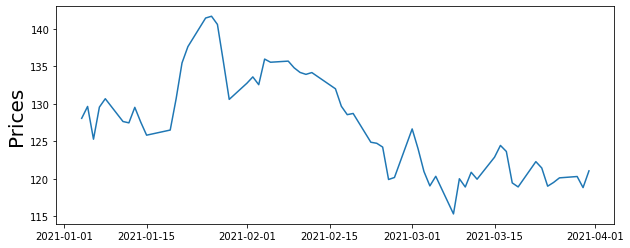

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(prices)
plt.ylabel("Prices", fontsize=20)

Text(0, 0.5, 'Return')

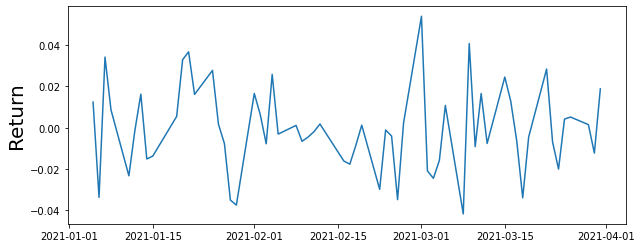

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(returns)
plt.ylabel("Return", fontsize=20)

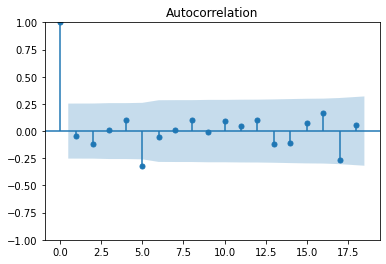

In [7]:
plot_acf(returns)
plt.show()

/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


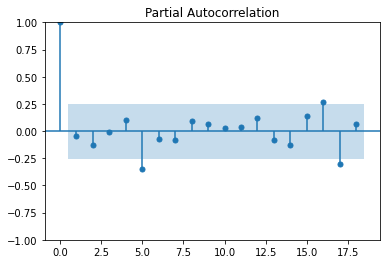

In [8]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying 

100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4426.00it/s]


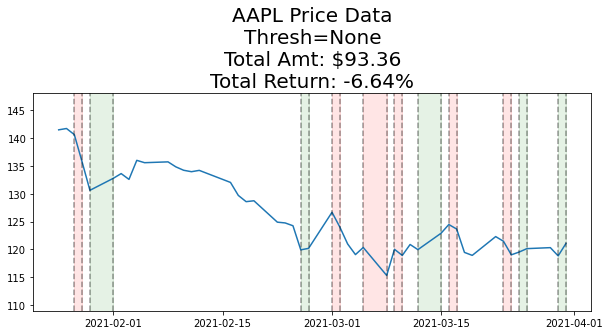

93.36315532816306

In [9]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [10]:
final_amts = [
    run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False)
    for _ in range(1000)
]

100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4702.02it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4160.93it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4237.79it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5004.75it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4653.14it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4137.81it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5310.56it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4626.48it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5484.93it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4630.47it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5537.83it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5634.54it/s]


100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5888.00it/s]


/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Avg: $95.27\nSD: $6.42')

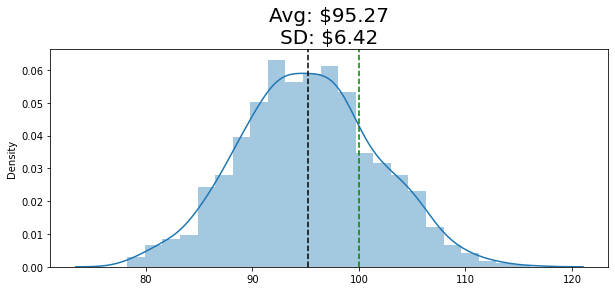

In [11]:
plt.figure(figsize=(10, 4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color="k", linestyle="--")
plt.axvline(100, color="g", linestyle="--")
plt.title(
    "Avg: $%s\nSD: $%s" % (round(np.mean(final_amts), 2), round(np.std(final_amts), 2)),
    fontsize=20,
)

# If Last Return was Positive, Buy

100%|█████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 4939.53it/s]


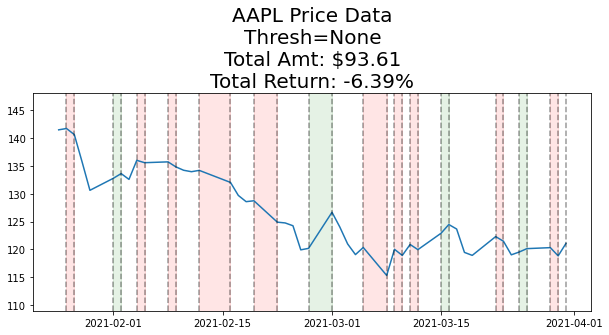

93.60997417682495

In [12]:
run_simulation(returns, prices, 100, "last", None, verbose=False)

# Try AR(1) Model

100%|███████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 28.48it/s]


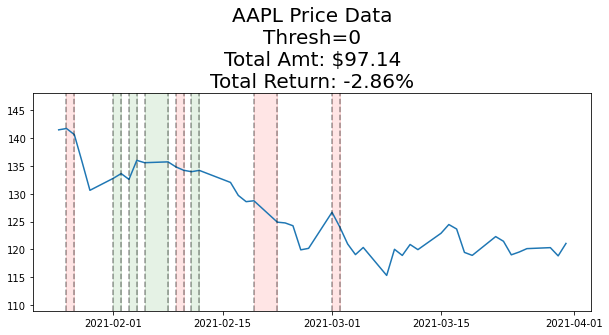

100%|███████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 27.91it/s]


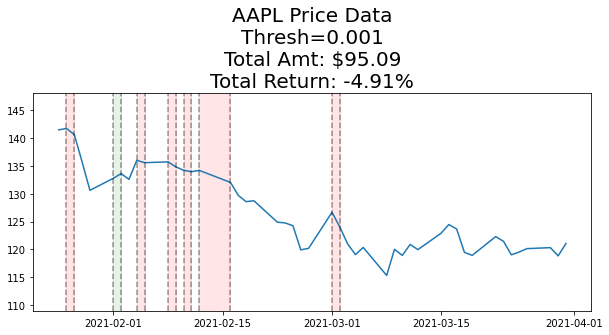

100%|███████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 25.05it/s]


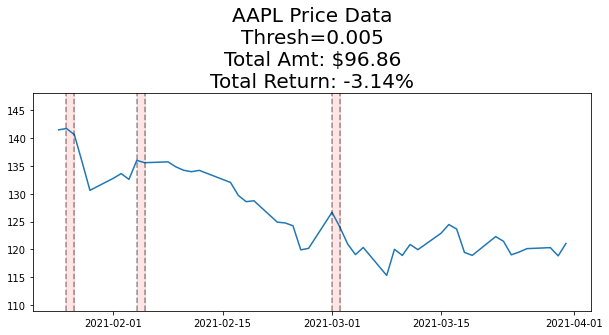

In [37]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1, 0, 0), thresh, verbose=False, plot=True)

# Try AR(5) Model

  4%|██▊                                                             | 2/46 [00:00<00:13,  3.38it/s]/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|███████████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.09it/s]


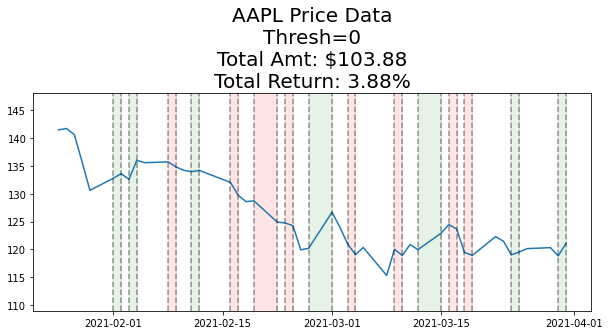

  4%|██▊                                                             | 2/46 [00:00<00:07,  5.74it/s]/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|███████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.38it/s]


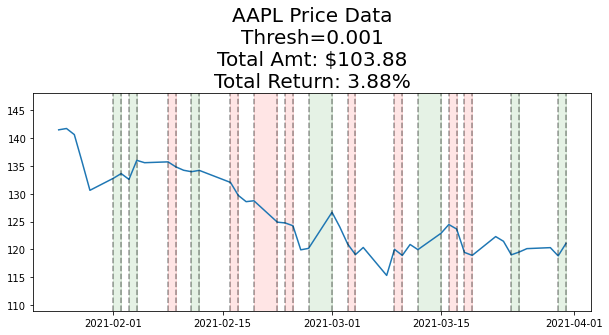

  4%|██▊                                                             | 2/46 [00:00<00:07,  5.71it/s]/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|███████████████████████████████████████████████████████████████| 46/46 [00:10<00:00,  4.35it/s]


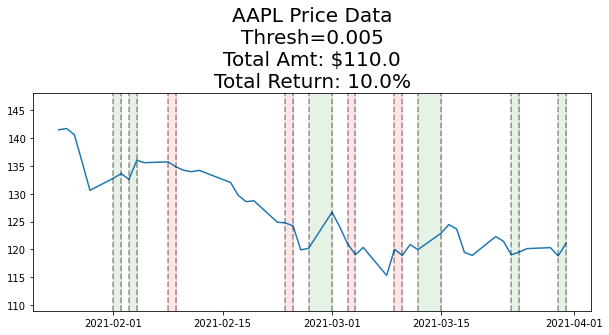

In [38]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5, 0, 0), thresh, verbose=False)

# Try ARMA(5,5) Model

  0%|                                                                        | 0/46 [00:00<?, ?it/s]/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
  4%|██▊                                                             | 2/46 [00:01<00:24,  1.79it/s]/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: User

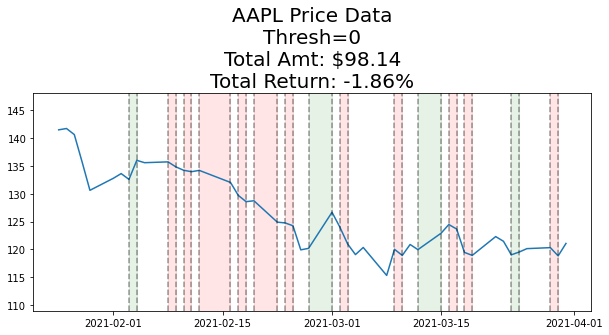

  0%|                                                                        | 0/46 [00:00<?, ?it/s]/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
  4%|██▊                                                             | 2/46 [00:02<01:00,  1.38s/it]/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: User

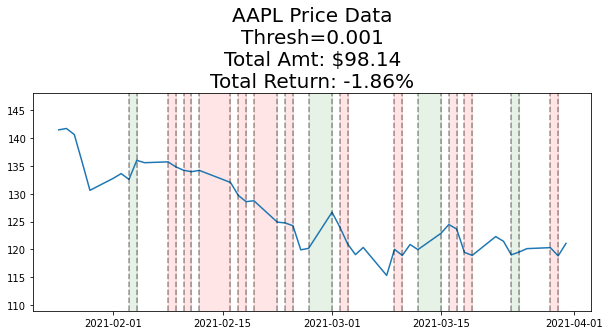

  0%|                                                                        | 0/46 [00:00<?, ?it/s]/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
  4%|██▊                                                             | 2/46 [00:01<00:26,  1.69it/s]/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: User

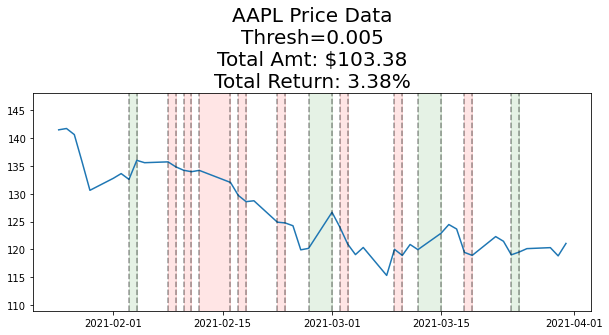

In [39]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5, 0, 5), thresh, verbose=False)